**This notebook details an experiment run on Amazon’s Mechanical Turk crowd sourcing system. They ask a bunch of raters (called “turks”) to rate several
urls, but they already know the answers (the true categories) for a few urls,
called the “gold set”. The ratings of the turks on the gold set thus allows us
to judge their accuracy.**

In [1]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Reading in data

First, we read in the files gold.txt and labels.txt. The gold DataFrame should
have columns url and category, while the labels DataFrame should have
columns turk, url and category.

In [2]:
## Read the .txt file using read_csv with the tab separator and name the columns accordingly.
## Also remove duplicates in both the gold and labels dataframes.
gold = pd.read_csv('gold.txt',sep='\t',names=['url','category']).drop_duplicates()
labels = pd.read_csv('labels.txt',sep='\t',names=['turk','url','category']).drop_duplicates()

In [3]:
## Print the number of records in both 
print(f'Number of records in Gold: {len(gold)}')
print(f'Number of records in Labels: {len(labels)}')

Number of records in Gold: 1517
Number of records in Labels: 89948


## Splitting into two DataFrames

Here, we split the labels DataFrame into two: labels on gold and labels unknown,
the former containing all rows where the url is present in the gold set, and
the latter one contains all remaining rows of labels.

In [4]:
## Find the rows in labels that have common urls with the Gold DF
labels_on_gold = labels[labels['url'].isin(gold['url'])]

## Sample Output
labels_on_gold

,turk,url,category
245,A1253FXHCZ9CWM,http://0800-horoscope.com,G
246,A153PKAL7OAY36,http://0800-horoscope.com,G
247,A1FV9SAPL5C6KY,http://0800-horoscope.com,G
248,A1JTOT0DWM6QGL,http://0800-horoscope.com,G
249,A1PXXEOGQ76RNJ,http://0800-horoscope.com,G
...,...,...,...
91766,A35CBDDGBM7T6E,http://yousendit.com,G
91767,A3J86MK3VIE6ST,http://yousendit.com,G
91768,A4GP97LAQCCHJ,http://yousendit.com,G
91769,AAQNUEUU7H1Y5,http://yousendit.com,G


In [5]:
## Subsets those rows from Labels DF that do not have a common url with the Gold DF
labels_unknown = labels[~labels['url'].isin(gold['url'])]

# Sample Output
labels_unknown

,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G
5,A2OVKTB7VNY8EW,http://000.cc,G
...,...,...,...
92716,AFHMR93GDJCGT,http://zz868.com,G
92717,A13F119AMOA54H,http://zzx.cc,X
92718,A1S0C0EB7A6FFM,http://zzx.cc,P
92719,A21US576U8SCO4,http://zzx.cc,G


## Computing accuracies of turks
Here, we create a rater goodness DataFrame that is indexed by turk, and has two
columns: the number of ratings, and the average correctness of ratings for
each turk (both on gold set urls).

In [6]:
## Merging the labels_on_gold DF with the gold DF on "url" to check the category given by 
## turks in the labels DF vs those in the gold DF

labels_gold_merge = labels_on_gold.merge(gold, 
                            left_on='url',
                            right_on='url',
                            how='inner',
                            suffixes=['_labels','_gold'])

## Creating a Category_Check column with 1/0 values which takes 1 if the category in labels matches 
## with the category in gold and 0 if it does not match.
labels_gold_merge['category_check'] = (labels_gold_merge['category_labels']==labels_gold_merge['category_gold']).astype('int')

#Sample Output
labels_gold_merge

,turk,url,category_labels,category_gold,category_check
0,A1253FXHCZ9CWM,http://0800-horoscope.com,G,G,1
1,A153PKAL7OAY36,http://0800-horoscope.com,G,G,1
2,A1FV9SAPL5C6KY,http://0800-horoscope.com,G,G,1
3,A1JTOT0DWM6QGL,http://0800-horoscope.com,G,G,1
4,A1PXXEOGQ76RNJ,http://0800-horoscope.com,G,G,1
...,...,...,...,...,...
3314,A35CBDDGBM7T6E,http://yousendit.com,G,G,1
3315,A3J86MK3VIE6ST,http://yousendit.com,G,G,1
3316,A4GP97LAQCCHJ,http://yousendit.com,G,G,1
3317,AAQNUEUU7H1Y5,http://yousendit.com,G,G,1


In [7]:
## Creating the rater_goodness dataframe with turks as the index, Number of correct ratings and 
## Average correctness of ratings as the two columns using groupby

rater_goodness = labels_gold_merge.groupby('turk')['category_check'].agg(['count','mean'])
rater_goodness.columns=['Number of ratings','Average correctness of ratings']

In [8]:
## Sample Output
rater_goodness

,Number of ratings,Average correctness of ratings
turk,,
A112DVP1KG4QZU,1,1.000000
A1253FXHCZ9CWM,29,0.517241
A12CY1Q7XKJJDE,1,1.000000
A12RE8G66WTO8B,20,0.750000
A12Y1GTGIQDGRA,3,0.333333
...,...,...
AYWOBMTEGFVVI,1,0.000000
AZ1S5BIG5R6P6,35,0.714286
AZSDW7JJL5VA7,100,0.680000


## Calculating Odds ratios
If someone is correct p fraction of the time, the odds of success are defined
as:<br>

$$
odds = \frac{p}{1.001-p}
$$

We attach a column called odds to the rater goodness DataFrame, using the
average correctness of the turk as his or her p.


In [9]:
## Creating a column "odds" with the mathematical formula
rater_goodness['odds'] = rater_goodness['Average correctness of ratings']/(1.001-rater_goodness['Average correctness of ratings'])

## Sample Output
rater_goodness

,Number of ratings,Average correctness of ratings,odds
turk,,,
A112DVP1KG4QZU,1,1.000000,1000.000000
A1253FXHCZ9CWM,29,0.517241,1.069214
A12CY1Q7XKJJDE,1,1.000000,1000.000000
A12RE8G66WTO8B,20,0.750000,2.988048
A12Y1GTGIQDGRA,3,0.333333,0.499251
...,...,...,...
AYWOBMTEGFVVI,1,0.000000,0.000000
AZ1S5BIG5R6P6,35,0.714286,2.491281
AZSDW7JJL5VA7,100,0.680000,2.118380


## Most accurate turks
Listing the top 10 most accurate turks who have rated at least 20 gold set URLs.

In [10]:
## Subsetting the 10 most Accurate turks with at least 20 ratings
rater_goodness[rater_goodness['Number of ratings']>=20].sort_values(by='Average correctness of ratings',ascending=False)[:10]

,Number of ratings,Average correctness of ratings,odds
turk,,,
A2U0R4X38GUKZE,20,0.950000,18.627451
A22C0PJUBFJTI0,36,0.916667,10.869565
A23YQUBXZPKILZ,24,0.875000,6.944444
ATVALOQVDCMZW,103,0.854369,5.826657
A1HIXWH4OXT8S4,40,0.825000,4.687500
A3220HG1O83HQ4,22,0.818182,4.475385
A32W20KGQXS0LL,25,0.800000,3.980100
A20PWAB7G3HDHU,20,0.800000,3.980100
AJSJVK40F5HM6,28,0.785714,3.649635


In [11]:
## Printing the top 10 turks

rater_goodness[rater_goodness['Number of ratings']>=20].sort_values(by='Average correctness of ratings',ascending=False)[:10].index

Index(['A2U0R4X38GUKZE', 'A22C0PJUBFJTI0', 'A23YQUBXZPKILZ', 'ATVALOQVDCMZW',
       'A1HIXWH4OXT8S4', 'A3220HG1O83HQ4', 'A32W20KGQXS0LL', 'A20PWAB7G3HDHU',
       'AJSJVK40F5HM6', 'A31OCN4MNHUQ6W'],
      dtype='object', name='turk')

## Rating counts versus accuracy
Is number of ratings by a turker on gold set URLs related to his or her
accuracy?

1. Create a scatter plot to compare 'Average correctness of ratings' and 'Number of ratings'.<br>
The scatter plot shows that most of the turks with number of ratings above ~20 have an average correctness of ratings between 0.5-0.9.

2. Print the correlation coefficient of the two columns.<br>
The correlation coefficient between 'Average correctness of ratings' and 'Number of ratings' is 0.0449 which means thats the two variables are not strongly correlated to each other. However, they do have a positive correlation coefficient which shows that you can see a good number of records where the 'Average correctness of ratings' goes up with the 'Number of ratings'

Text(0, 0.5, 'Number of ratings')

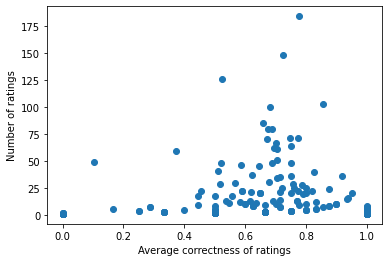

In [12]:
## Plotting a scatter graph to understand the distribution of Average Correctness of Ratings and Number of Ratings
plt.scatter(rater_goodness['Average correctness of ratings'],rater_goodness['Number of ratings'])
plt.xlabel('Average correctness of ratings')
plt.ylabel('Number of ratings')

In [13]:
## Checking the correlation between Average Correctness of Ratings and Number of Ratings

import numpy as np
np.corrcoef(rater_goodness['Average correctness of ratings'],rater_goodness['Number of ratings'])

array([[1.        , 0.04498264],
       [0.04498264, 1.        ]])

## Overall predicted odds
First, we consider each url u that is not in the gold set, and each category c. For the
pair (u, c), we calculate the product of odds of all turks who (a) rated url u as
category c, and (b) have rated more gold set urls than 75% of all turks who
rated at least one gold-set url.

In [27]:
## Subsetting the data of those turks that have number of ratings more than 75% of the 
## other turks who rated atleast one gold-set url adn sorting values in descending order of Number of Ratings
reliable_raters = rater_goodness[rater_goodness['Number of ratings'] > rater_goodness['Number of ratings'].quantile(q=0.75)].sort_values(by='Number of ratings', ascending=False)

## Sample Output
reliable_raters

,Number of ratings,Average correctness of ratings,odds
turk,,,
A31OCN4MNHUQ6W,184,0.777174,3.472222
A153PKAL7OAY36,148,0.722973,2.600369
A2BTR0GQ5B5JI6,126,0.523810,1.097695
ATVALOQVDCMZW,103,0.854369,5.826657
AZSDW7JJL5VA7,100,0.680000,2.118380
...,...,...,...
A8XTEV2JA6R2X,13,0.692308,2.242711
AV30XWLULCP43,13,0.615385,1.595851
A18HIFA78GUAG9,13,0.538462,1.164144


In [28]:
## Merging the reliable_raters set with the unknown labels DF to find those URLs 
## with unsure category rated by the reliable raters
raters_labels_unknown = reliable_raters.merge(labels_unknown, 
                            left_on='turk',
                            right_on='turk')

## Sample Output
raters_labels_unknown

,turk,Number of ratings,Average correctness of ratings,odds,url,category
0,A31OCN4MNHUQ6W,184,0.777174,3.472222,http://000webhost.com,G
1,A31OCN4MNHUQ6W,184,0.777174,3.472222,http://007absolutehardcore.com/early_cumshots/...,X
2,A31OCN4MNHUQ6W,184,0.777174,3.472222,http://10000birds.com,G
3,A31OCN4MNHUQ6W,184,0.777174,3.472222,http://100bestdatingsites.com,R
4,A31OCN4MNHUQ6W,184,0.777174,3.472222,http://101fetishes.com/femdomtorture/portal.htm,X
...,...,...,...,...,...,...
37993,A4GP97LAQCCHJ,12,0.583333,1.396648,http://zooass.com,G
37994,A4GP97LAQCCHJ,12,0.583333,1.396648,http://zoozle.org,G
37995,A4GP97LAQCCHJ,12,0.583333,1.396648,http://zses.com,G
37996,A4GP97LAQCCHJ,12,0.583333,1.396648,http://zshare.net,G


In [29]:
## Creating a dataframe with a column that stores the product of odds of all turks who 
## rated a particular URL to a particular category
odds_prod = raters_labels_unknown.groupby(['url','category'])['odds'].agg(['prod'])
odds_prod.columns=['Overall Odds']

## Sample Output
odds_prod

Overall Odds
url                         category              
http://0-101.net            G             2.297602
http://000.cc               G             1.485456
http://0000.jp              G            14.339248
http://000relationships.com G             3.841962
                            P             1.851852
...                                            ...
http://zynga.com            G             3.666513
http://zz868.com            G             1.047852
                            P             1.851852
http://zzx.cc               G             1.417620
                            X             1.620746

[13983 rows x 1 columns]

## Predicted categories
We create a DataFrame (called result 75, whose index is URLs not in the gold
set, and with two columns called top category and top odds. The top
category should be the category with the highest overall odds for that url,
and the top odds should be the overall odds for that top category

In [30]:
## Creating the result_75 DF that looks for the indices of the max 'prod' and locates those indices and 
## corresponding prod thus giving us a DF unique on URLs (after resetting the index)
result_75 = odds_prod.loc[odds_prod.groupby('url')['Overall Odds'].idxmax()]
result_75 = result_75.reset_index().set_index('url')

## Sample Output
result_75

,category,Overall Odds
url,,
http://0-101.net,G,2.297602
http://000.cc,G,1.485456
http://0000.jp,G,14.339248
http://000relationships.com,G,3.841962
http://000vitamins.com,G,4.033641
...,...,...
http://zwinky.com,G,17.201875
http://zylom.com,G,1.849543
http://zynga.com,G,3.666513


## Predicting categories using more turks
Here, we repeat the code above, but replacing 75% by 25% in the description of Q7 (i.e., we also consider turks who have far fewer gold set ratings). We call this result_25.<br>
Now let’s see how these two results compare. To do so, we create a DataFrame where
both the index and the columns are the various categories, and the cells
contain the number of urls with these as the top categories according to
result_75 and result_25.<br>
For example, the cell corresponding to the row category=R and the column category=G would be the number of URLs that were predicted to be
R by result_75 but predicted to be G by result_25.


<b>INFERENCE:</b>
As we can see from the crosstab, the maximum errors i.e., 586 errors, were for URLs that we classfied as <b>G</b> by result_75, but classified as <b>P</b> by result_25.


In [31]:
## Subsetting the data of those turks that have number of ratings more than 25% of the 
## other turks who rated atleast one gold-set url and sorting values in descending order of Number of Ratings

raters_25 = rater_goodness[rater_goodness['Number of ratings'] > rater_goodness['Number of ratings'].quantile(q=0.25)].sort_values(by='Number of ratings', ascending=False)

## Sample Output
raters_25

,Number of ratings,Average correctness of ratings,odds
turk,,,
A31OCN4MNHUQ6W,184,0.777174,3.472222
A153PKAL7OAY36,148,0.722973,2.600369
A2BTR0GQ5B5JI6,126,0.523810,1.097695
ATVALOQVDCMZW,103,0.854369,5.826657
AZSDW7JJL5VA7,100,0.680000,2.118380
...,...,...,...
AAQNUEUU7H1Y5,2,1.000000,1000.000000
A2FF1R5VPUVTLE,2,1.000000,1000.000000
A1UKUDGXMHTYAR,2,1.000000,1000.000000


In [32]:
## Merging the reliable_raters set with the unknown labels DF to find those URLs 
## with unsure category rated by the reliable raters
raters_labels_unknown_25 = raters_25.merge(labels_unknown, 
                            left_on='turk',
                            right_on='turk')

## Sample Output
raters_labels_unknown_25

,turk,Number of ratings,Average correctness of ratings,odds,url,category
0,A31OCN4MNHUQ6W,184,0.777174,3.472222,http://000webhost.com,G
1,A31OCN4MNHUQ6W,184,0.777174,3.472222,http://007absolutehardcore.com/early_cumshots/...,X
2,A31OCN4MNHUQ6W,184,0.777174,3.472222,http://10000birds.com,G
3,A31OCN4MNHUQ6W,184,0.777174,3.472222,http://100bestdatingsites.com,R
4,A31OCN4MNHUQ6W,184,0.777174,3.472222,http://101fetishes.com/femdomtorture/portal.htm,X
...,...,...,...,...,...,...
63443,A2KFMGXME2SGI,2,0.000000,0.000000,http://worldnetdaily.com,G
63444,A2KFMGXME2SGI,2,0.000000,0.000000,http://wwtdd.com,G
63445,A2KFMGXME2SGI,2,0.000000,0.000000,http://www5d.biglobe.ne.jp/~torihiro,G
63446,A2KFMGXME2SGI,2,0.000000,0.000000,http://wyunion.com,G


In [33]:
## Creating a dataframe with a column that stores the product of odds of all turks who 
## rated a particular URL to a particular category
odds_prod_25 = raters_labels_unknown_25.groupby(['url','category'])['odds'].agg(['prod'])
odds_prod_25.columns=['Overall Odds']

## Sample Output
odds_prod_25

Overall Odds
url                         category              
http://0-101.net            G         2.297602e+00
http://000.cc               G         2.218192e+03
                            P         9.980040e-01
http://0000.jp              G         2.847963e+07
http://000relationships.com G         0.000000e+00
...                                            ...
http://zz868.com            G         1.209566e+13
                            P         1.851852e+00
http://zzx.cc               G         1.417620e+00
                            P         9.980040e-01
                            X         1.620746e+00

[16690 rows x 1 columns]

In [34]:
## Creating the result_25 DF that looks for the indices of the max 'prod' and locates those indices and 
## corresponding prod thus giving us a DF unique on URLs (after resetting the index)
result_25 = odds_prod_25.loc[odds_prod_25.groupby('url')['Overall Odds'].idxmax()]
result_25 = result_25.reset_index().set_index('url')

## Sample Output
result_25

,category,Overall Odds
url,,
http://0-101.net,G,2.297602e+00
http://000.cc,G,2.218192e+03
http://0000.jp,G,2.847963e+07
http://000relationships.com,P,1.851852e+00
http://000vitamins.com,G,5.343559e+00
...,...,...
http://zwinky.com,P,1.000000e+03
http://zylom.com,G,3.062113e+03
http://zynga.com,G,5.386158e+01


In [35]:
## Resetting the indices of result_25 and result_75 to convert them into indexable dataframes.
result_25 = result_25.reset_index()
result_75 = result_75.reset_index()

In [36]:
## Inner join on URL to get only common URLs between the two dataframes.
merge = result_25.merge(result_75, 
                            left_on='url',
                            right_on='url')

## Sample Output
merge

,url,category_x,Overall Odds_x,category_y,Overall Odds_y
0,http://0-101.net,G,2.297602e+00,G,2.297602
1,http://000.cc,G,2.218192e+03,G,1.485456
2,http://0000.jp,G,2.847963e+07,G,14.339248
3,http://000relationships.com,P,1.851852e+00,G,3.841962
4,http://000vitamins.com,G,5.343559e+00,G,4.033641
...,...,...,...,...,...
10605,http://zwinky.com,P,1.000000e+03,G,17.201875
10606,http://zylom.com,G,3.062113e+03,G,1.849543
10607,http://zynga.com,G,5.386158e+01,G,3.666513
10608,http://zz868.com,G,1.209566e+13,P,1.851852


In [37]:
## Creating a crosstab between the categories from both these dataframes to get distribution of common categories.
pd.crosstab(merge['category_y'],merge['category_x'],rownames=['Result_75 Categories'], colnames=['Result_25 Categories'])

Result_25 Categories,G,P,R,X
Result_75 Categories,,,,
G,8280,586,180,214
P,196,352,52,25
R,22,34,127,25
X,28,5,28,456


## END OF CODE